In [1]:
import pandas as pd
from fastai import *
from fastai.text import *
from pathlib import Path

MODEL_P = Path('../lawstats/model/')
DATA_P = Path('../lawstats/data/')

In [2]:
corpus_df = pd.read_csv(DATA_P / 'corpus.tsv', delimiter='\t', header=None, names=['DecisionID', 'DecisionText'])
bgh_df = pd.read_csv(DATA_P / 'bgh_data.csv')

In [5]:
merged_data = pd.merge(corpus_df, bgh_df[['DecisionID', 'RevisionOutcome']], on='DecisionID')
merged_data.head()

,DecisionID,DecisionText,RevisionOutcome
0,verdict41720,Die Beschwerde gegen die Nichtzulassung der ...,-1
1,verdict41716,Die Rechtsbeschwerde gegen den Beschluss der...,-1
2,verdict41717,Die Anhörungsrüge gegen den Senatsbeschluss ...,-1
3,verdict41710,1_ Auf die Revision des Angeklagten wird d...,1
4,verdict41711,Die Anhörungsrüge gegen den Senatsbeschluss ...,-1


**Language Model**

First a word level Language Model is trained, so that the word embeddings can be pretrained to be later used with the language classifier.

There is probably an easy improvement to be made with using a german wikitext language model instead of random weights.

In [6]:
data_lm = (TextList.from_df(merged_data[['DecisionText']], MODEL_P)
           .split_by_rand_pct(0.1)
           .label_for_lm().databunch())

In [38]:
data_lm.save('lm_databunch')

In [7]:
data_lm.show_batch()

idx,text
0,wird auf xxmaj kosten der xxmaj schuldnerin als unzulässig verworfen . xxbos xxmaj die xxmaj anhörungsrüge gegen den xxmaj senatsbeschluss vom 23 - 11 - 2006 wird auf xxmaj kosten des xxmaj schuldners zurückgewiesen . xxbos 1 _ xxmaj auf die xxmaj revision des xxmaj angeklagten wird das xxmaj urteil des xxmaj landgerichts xxmaj magdeburg vom 14 - 3 - 2007 i m xxmaj ausspruch über die xxmaj gesamtstrafe mit
1,"beschluss des 3 _ xxmaj senats für xxmaj familiensachen des xxmaj brandenburgischen xxmaj oberlandesgerichts vom 15 - 8 - 2011 wird auf xxmaj kosten des xxmaj antragsgegners verworfen . xxbos xxmaj die xxmaj revision des xxmaj angeklagten gegen das xxmaj urteil des xxmaj landgerichts xxmaj wuppertal vom 5 - 12 - 2002 wird als unbegründet verworfen , da die xxmaj nachprüfung des xxmaj urteils auf xxmaj grund der xxmaj revisionsrechtfertigung"
2,"landgerichts xxmaj hannover vom 7 - 6 - 2007 wirksam zurückgenommen ist . xxbos xxmaj die übrigen xxmaj voraussetzungen für die xxmaj anordnung der xxmaj xxunk liegen vor . xxbos xxmaj auf die xxmaj revision der xxmaj kläger wird das xxmaj urteil des 13 _ xxmaj zivilsenats in xxmaj darmstadt des xxmaj oberlandesgerichts xxmaj frankfurt am xxmaj main vom 12 - 6 - 2002 aufgehoben . xxbos "" xxmaj unter"
3,xxmaj revision der xxmaj klägerin wird das xxmaj urteil der 15 _ xxmaj zivilkammer des xxmaj landgerichts xxmaj münchen i vom 17 - 12 - 2003 aufgehoben . xxbos xxmaj die xxmaj revision gegen das xxmaj urteil der 2 _ xxmaj zivilkammer des xxmaj landgerichts xxmaj aurich vom 28 - 5 - 2004 wird auf xxmaj kosten der xxmaj kläger zurückgewiesen . xxbos xxmaj die xxmaj revision des xxmaj angeklagten
4,- 7 - 2012 b ) i m xxmaj ausspruch über die xxmaj gesamtstrafe und c ) soweit eine xxmaj entscheidung über die xxmaj anordnung der xxmaj unterbringung in einer xxmaj entziehungsanstalt unterblieben ist . xxbos xxmaj die xxmaj beschwerde der xxmaj klägerin gegen die xxmaj nichtzulassung der xxmaj revision in dem xxmaj urteil des 13 _ xxmaj zivilsenats in xxmaj darmstadt des xxmaj oberlandesgerichts xxmaj frankfurt am xxmaj main


In [41]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):
        if metrics:
            loss, acc = metrics[0], metrics[1]
            if not self.best_acc or acc > self.best_acc:
                self.best_acc = acc
                self.best_loss = loss
                self.learn.save(f'{self.name}')
                print("Save the best accuracy {:.5f}".format(self.best_acc))
            elif acc == self.best_acc and  loss < self.best_loss:
                self.best_loss = loss
                self.learn.save(f'{self.name}')
                print("Accuracy is eq,Save the lower loss {:.5f}".format(self.best_loss))

    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

In [8]:
learner = language_model_learner(data_lm, arch=AWD_LSTM, pretrained=False, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


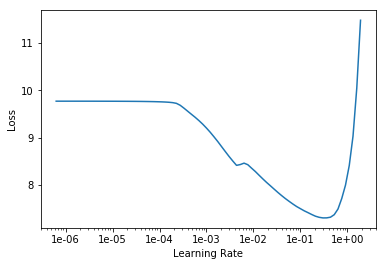

In [9]:
#find a suitable learning rate
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [10]:
learner.fit_one_cycle(8, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.442637,1.963066,0.614893,03:43
1,1.797330,1.498584,0.670740,03:49
2,1.544983,1.365041,0.688535,03:49
3,1.574180,1.308872,0.696915,03:50
4,1.360877,1.270674,0.704672,03:50
5,1.332223,1.246053,0.710807,03:49
6,1.204823,1.243872,0.713498,03:50
7,1.026412,1.249295,0.713613,03:50


In [11]:
learner.save('end_training_model_lm')
learner.save_encoder('full_corpus_lm_encoder')
learner.export('production_model.pkl')

In [83]:
text = learner.predict('Das Urteil', 100, temperature=1.5, min_p=0.001)
text = text.replace('xxbos ', '')
text

'Das Urteil des 3 _ Strafsenats des Oberlandesgerichts München vom 12 - 6 - 2005 , das gemäß § 13 Abs _ 1 bis 3 TKG , einschließlich eines Gesetzes nach § 22 a stpo und nach § 250 a AGBG i m Mai 2007 wegen eines offensichtlichen Schreibversehens i m Rubrum dem Randnummer 27 i m Leitsatz als abgesehen eingestellt wird , wenn das bei der Entscheidung über die Rechtsbeschwerde in dem angefochtenen Beschluss zutreffend gestellt wird . Auf die Gegenvorstellung des'